In [1]:
#Hide warnings when logging
from tensorflow.compat.v1.logging import set_verbosity,ERROR
set_verbosity(ERROR) 

from Utils import *

Using TensorFlow backend.


In [2]:
def LoadDF(name,dom=(210,400),weight=(-0.3,1.6,0.3)):
    """name = /path/to/file to load
    dom: Clean data. Cut from t=dom[0] to t=dom[1]. This is determined by plotting t vs T. 
        Default values ar ok for this datasets
    weight: Give importance to data in the range from (-0.3,1.2) by a factor of 0.7"""    
    df = (read_csv(name,encoding='utf-16',
                   skiprows=80,header=None,sep='[ ,\t]',
                   engine='python',names=['t','x','W','H','c','v','f'])
          .astype(float)
          .drop(columns=['H','c','v','f']))

    df = df[(df['t'] > dom[0]) & (df['t'] < dom[1] )].reset_index(drop=True) 
    df['W/%']=df['W']*100.0/df['W'].iloc[0]
    df.columns = ['t','x','W','y']
    
    dfn,norm_prms = normalize(df)

    mx,my,sx,sy = norm_prms
    w0 = weight[0]*sx+mx
    w1 = weight[1]*sy+my
    
    #dfR=weigh(df,weight[2],Range=(w0,w1))
    #dfR=weigh(df,0.3,Range=(0.0,1e-5))
    
    return dfn,norm_prms

In [8]:
names = !ls data/*txt
names = [file for file in names if file.split('/')[-1][:5] in ['La0.7']]

dfs = {}
for name in names:
    df,NormPrms = LoadDF(name,dom=(210,600))        #Load data
    mx,my,sx,sy=NormPrms
    #df.x = df.x*sx + mx
    #df.y = df.y*sy + my
    dfs[name] = df
    print(f"{name} successfully loaded.")

data/La0.7Ca0.3NiO310C.txt successfully loaded.
data/La0.7Ca0.3NiO315C.txt successfully loaded.
data/La0.7Ca0.3NiO35C.txt successfully loaded.
data/La0.7Ca0.3NiO38C.txt successfully loaded.


[273.79429639762014, 273.767457456908, 273.8020102464959, 273.80641343535825]

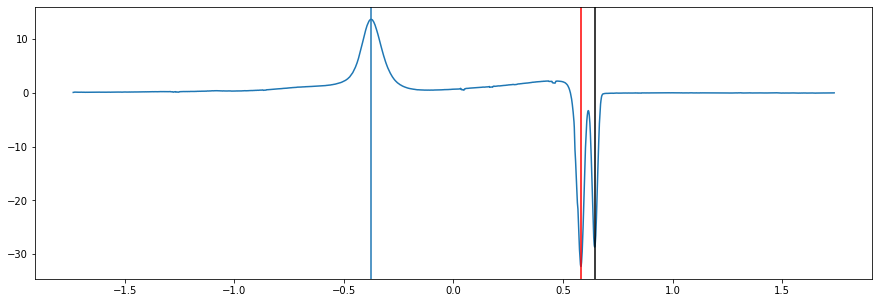

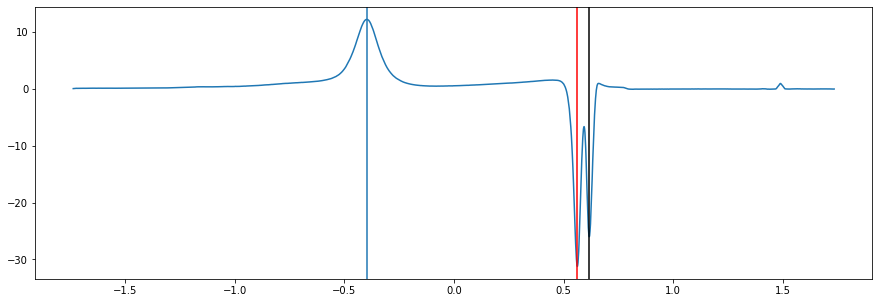

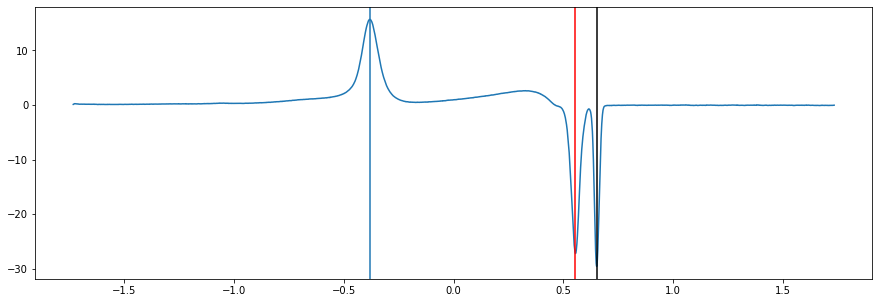

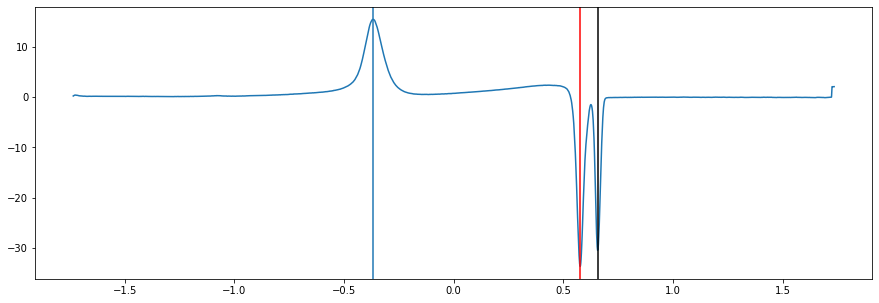

In [9]:
def smooth(y, box_pts=30):
    box = ones(box_pts)/box_pts
    y_smooth = convolve(y, box, mode='same')
    return y_smooth

ts = []
bs = []
for i in dfs.keys():#['data/La0.9Ca0.1NiO310C.txt', 'data/La0.9Ca0.1NiO315C.txt', 'data/La0.9Ca0.1NiO38C.txt']:
    df = dfs[i]
    deriv = diff(df.y)/diff(df.x)
    deriv = smooth(deriv,30)#*40

    peak1 = find_peaks(deriv,height=5,prominence=1)[0][0]
    pk = df.x.iloc[peak1]

    peak2 = find_peaks(-deriv,height=0.35,prominence=0.2)[0]
    if len(peak2)==1:
         pk1 = df.x.iloc[peak2].values[0]
    if len(peak2)==2:
         pk1,pk2 = df.x.iloc[peak2].values
    
    ts.append(pk2+273.15)
    bs.append(int(i.split('.')[2].split('3')[-1][:-1]))    
    
    fig,ax = subplots(figsize=(15,5))
    ax.plot(df.x.iloc[:-1],deriv)
    ax.axvline(x=pk)
    
    
    ax.axvline(x=pk1,color='r')
    if len(peak2)==2:
        ax.axvline(x=pk2,color='k')
ts

LinregressResult(slope=-167350.12130035646, intercept=128.16822251643202, rvalue=-0.7911962871017966, pvalue=0.20880371289820338, stderr=91467.64377807187)


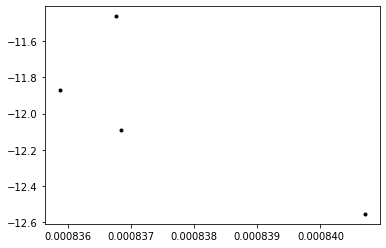

In [34]:
xs = [1/t for t in ts]
ys = [log(b/(t**2)) for b,t in zip(bs,ts)]

print(linregress(xs,ys))
plot(xs,ys,'k.')

In [26]:
-136129 #sin el punto
-152553 #con todos

[-11.815532841235244,
 -11.416307356364815,
 -12.508524086704853,
 -12.034276834551706]

In [36]:
ys

[-11.87147129377543,
 -11.463889292004106,
 -12.553118906684494,
 -12.09230080035965]

In [38]:
dfs.keys()

dict_keys(['data/La0.9Ca0.1NiO310C.txt', 'data/La0.9Ca0.1NiO315C.txt', 'data/La0.9Ca0.1NiO35C.txt', 'data/La0.9Ca0.1NiO38C.txt'])